# **Mini Project: Implement MLP from scratch to classify digits from MNIST Dataset**

Input: 784 (28 x 28)

Hidden: 128 (ReLU)

Output: 10 (Softmax)

## Step 1: Setup

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# For reproducibility
np.random.seed(42)

## Step 2: Load Data

In [ ]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X = mnist.data.astype(np.float32) / 255.0
y = mnist.target.astype(np.int32).reshape(-1, 1)

print("Feature shape:", X.shape)
print("Label shape:", y.shape)



Feature shape: (70000, 784)
Label shape: (70000, 1)


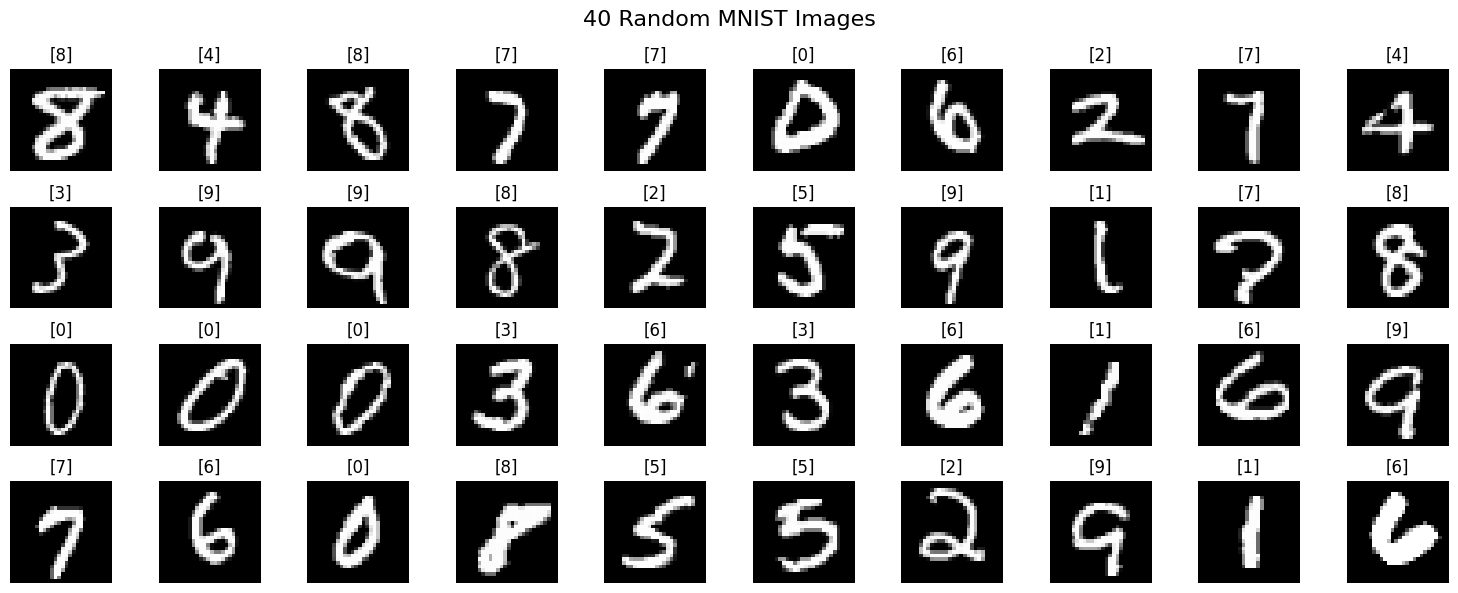

In [ ]:
### Display random images

indices = np.random.choice(len(X), 40, replace=False)

fig, axes = plt.subplots(4, 10, figsize=(15, 6))
fig.suptitle("40 Random MNIST Images", fontsize=16)

for i, ax in enumerate(axes.flat):
    idx = indices[i]
    ax.imshow(X[idx].reshape(28, 28), cmap='gray')
    ax.set_title(f"{y[idx]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## Step 3: Process data

In [ ]:
# One-hot encode labels
encoder = OneHotEncoder(sparse_output=False)
Y = encoder.fit_transform(y)

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

## Step 4: Initialize Parameters

In [ ]:
def init_weights(input_size, hidden_size, output_size):
    W1 = np.random.randn(input_size, hidden_size) * 0.01
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.randn(hidden_size, output_size) * 0.01
    b2 = np.zeros((1, output_size))
    return W1, b1, W2, b2

## Step 5: Activation and Loss function

In [ ]:
def relu(x):
  return np.maximum(0, x)

def relu_derivative(x):
  return (x>0).astype(np.float32)

def softmax(x):
  exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
  return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy(preds, labels):
    return -np.mean(np.sum(labels * np.log(preds + 1e-9), axis=1))


## Step 6: Forward pass and Backward pass

In [ ]:
def forward(X, W1, b1, W2, b2):
  Z1 = X @ W1 + b1
  A1 = relu(Z1)
  Z2 = A1 @ W2 + b2
  A2 = softmax(Z2)
  return Z1, A1, Z2, A2

def backward(X, Y, Z1, A1, Z2, A2, W1, W2):
  m = X.shape[0]
  dZ2 = (A2 - Y) / m
  dW2 = A1.T @ dZ2
  db2 = np.sum(dZ2, axis=0, keepdims=True)

  dA1 = dZ2 @ W2.T
  dZ1 = dA1 * relu_derivative(Z1)
  dW1 = X.T @ dZ1
  db1 = np.sum(dZ1, axis=0, keepdims=True)
  return dW1, db1, dW2, db2

## Step 7: Training

In [ ]:
input_size = 784
hidden_size = 8
output_size = 10

W1, b1, W2, b2 = init_weights(input_size, hidden_size, output_size)

lr = 0.1
epochs = 10

batch_size = 64

loss_history = []
accuracy_history = []
test_accuracy_history = []

best_train_acc = 0
best_epoch = 0
best_weights = None

for epoch in range(epochs):
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)

    epoch_losses = []
    epoch_accuracies = []

    for start in range(0, len(indices), batch_size):
        end = start + batch_size
        batch_indices = indices[start:end]
        X_batch, Y_batch = X_train[batch_indices], Y_train[batch_indices]

        Z1, A1, Z2, A2 = forward(X_batch, W1, b1, W2, b2)

        loss = cross_entropy(A2, Y_batch)
        pred_classes = np.argmax(A2, axis=1)
        true_classes = np.argmax(Y_batch, axis=1)
        accuracy = np.mean(pred_classes == true_classes)

        epoch_losses.append(loss)
        epoch_accuracies.append(accuracy)

        dW1, db1, dW2, db2 = backward(X_batch, Y_batch, Z1, A1, Z2, A2, W1, W2)

        W1 -= lr * dW1
        b1 -= lr * db1
        W2 -= lr * dW2
        b2 -= lr * db2

        if accuracy > best_train_acc:
            best_train_acc = accuracy
            best_epoch = epoch + 1
            best_weights = (W1.copy(), b1.copy(), W2.copy(), b2.copy())

    # Record epoch-wise stats
    loss_history.append(np.mean(epoch_losses))
    accuracy_history.append(np.mean(epoch_accuracies))

    print(f"Epoch {epoch+1} — Loss: {loss_history[-1]:.4f} — Train Acc: {accuracy_history[-1]*100:.2f}%")
    print(f"""Updated Weights:
  - W1 (first 2x2):
  {W1[:hidden_size, :hidden_size]}

  - b1 (first 2):
  {b1[:hidden_size]}

  - W2 (second 2x2):
  {W2[:hidden_size, :hidden_size]}

  - b2 (second 2):
  {b2[:hidden_size]}
  """)


Epoch 1 — Loss: 0.7506 — Train Acc: 76.60%
Updated Weights:
  - W1 (first 2x2):
  [[ 0.00508598 -0.00248149  0.00239665  0.00190277  0.00148518 -0.00413579
   0.00906582 -0.00848866]
 [ 0.00265302  0.00390174 -0.00195532  0.00793249 -0.00465139  0.02296816
   0.00236599  0.01238312]
 [ 0.00888052  0.01423543  0.00088081  0.01127135  0.01455997  0.00287998
  -0.00698565  0.01829759]
 [ 0.00019011  0.00078581  0.00270339 -0.00783227  0.00340135  0.00348227
  -0.00010089 -0.00066587]
 [-0.00222193 -0.00380119  0.00726584  0.00290347  0.00931211 -0.00521478
   0.01127799  0.00891439]
 [-0.00242915 -0.00666274  0.00594718 -0.01586006 -0.00415035  0.00275488
  -0.00149819 -0.01071203]
 [ 0.00090391 -0.00998803  0.00260752 -0.0039143  -0.00138453 -0.00822067
   0.00773777 -0.00146059]
 [-0.00738005 -0.00120735  0.0173482   0.00334805  0.01075869 -0.01611668
  -0.00197366 -0.00999921]]

  - b1 (first 2):
  [[-0.00328417 -0.04462063 -0.01605528  0.2300341  -0.05922831  0.09828668
   0.10737361 

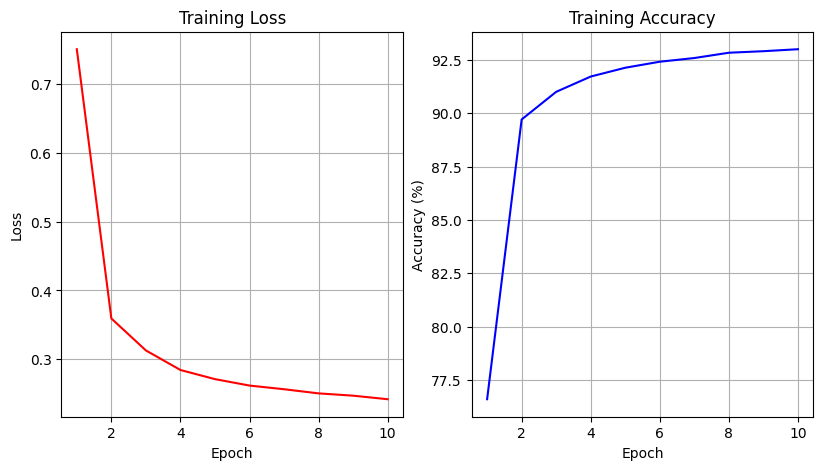

In [ ]:
import matplotlib.pyplot as plt

epochs = len(loss_history)

plt.figure(figsize=(15, 5))

# Loss
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs + 1), loss_history, color='red')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# Training Accuracy
plt.subplot(1, 3, 2)
plt.plot(range(1, epochs + 1), [a * 100 for a in accuracy_history], label='Train Accuracy', color='blue')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)


## Step 8: Evaluate


Final Test Accuracy (best model from epoch 2): 90.28%


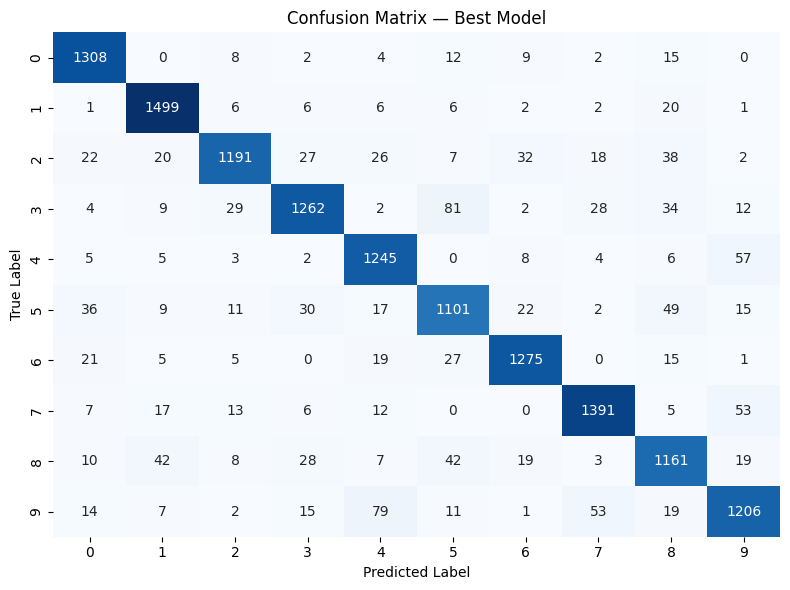

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Unpack the best weights
W1_best, b1_best, W2_best, b2_best = best_weights

# Forward pass on test set
_, _, _, A2_test = forward(X_test, W1_best, b1_best, W2_best, b2_best)
y_pred = np.argmax(A2_test, axis=1)
y_true = np.argmax(Y_test, axis=1)

# Accuracy and confusion matrix
final_test_acc = np.mean(y_pred == y_true)
print(f"\nFinal Test Accuracy (best model from epoch {best_epoch}): {final_test_acc * 100:.2f}%")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix — Best Model")
plt.tight_layout()
plt.show()


Correctly classified: 12639
Incorrectly classified: 1361


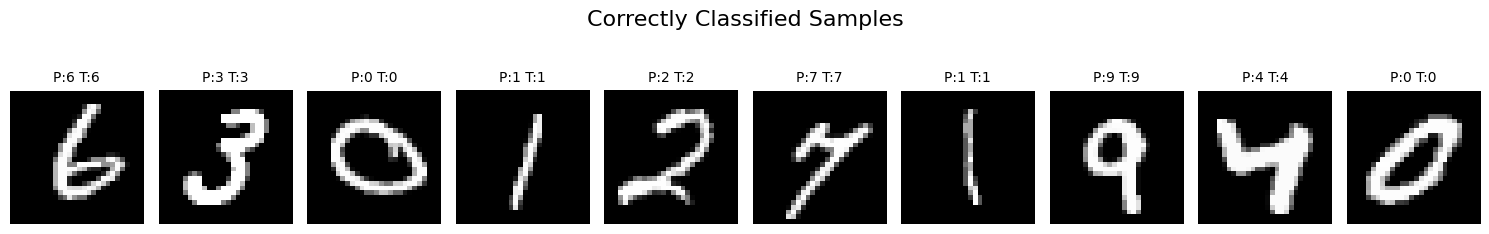

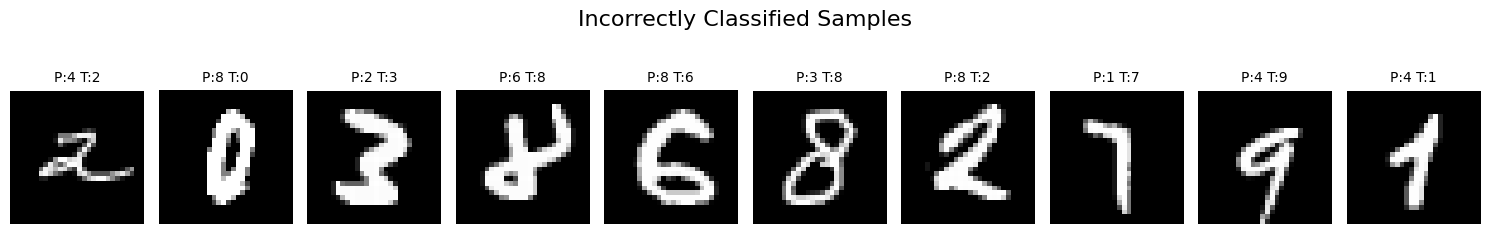

In [ ]:
correct_indices = np.where(y_pred == y_true)[0]
incorrect_indices = np.where(y_pred != y_true)[0]
print(f"Correctly classified: {len(correct_indices)}")
print(f"Incorrectly classified: {len(incorrect_indices)}")
import matplotlib.pyplot as plt

def plot_examples(indices, title, num=10):
    np.random.seed()  # Ensures true randomness each run
    sample_indices = np.random.choice(indices, size=min(num, len(indices)), replace=False)

    plt.figure(figsize=(15, 2.5))
    for i, idx in enumerate(sample_indices):
        plt.subplot(1, num, i + 1)
        plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
        plt.title(f"P:{y_pred[idx]} T:{y_true[idx]}", fontsize=10)
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

# Show correct and incorrect samples
plot_examples(correct_indices, "Correctly Classified Samples")
plot_examples(incorrect_indices, "Incorrectly Classified Samples")